In [3]:
import urllib.request
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import folium # map rendering library

print('Initialization Complete.')

Initialization Complete.


### PROBLEM DESCRIPTION:

The problem to be addressed is based on the following situation;

Situation:
A client wants to start a high-end Sushi restaurant in the city of Toronto. A big requirement is to have the lowest possible pay-back period. The client is willing to set up the business in any suitable neighborhood in the city of Toronto. 

Problem: The requirement for quick pay-back/ROI means that the location must ensure the most business in terms of customers visits. In additon, the new restaurant has to be located where there are currently few or no restaurants of the same type.

Solution: Using publicly available data and Data Science tools, identifying the best neighborhood to start a restaurant will be attempted.

### NOTE:
A Prime criterion for any business investment is location. Clustering was not used to determine the location for the restaurant as that technique only aggregates or clusters venues of a similar type (least variance) and thus does not fulfill the requirment of the client to find a location that provides the maximum return in the shortest time. Instead, the best location is chosen for the criterion of a location with the most density of businesses (venue categories). 


#### Note on dataset
The data used to do the analysis is from a file that is called 'toronto_data.csv'. This file contains the attributes Neighborhood, Borough and the respective Latitude and Longitudes. 

##### How the dataset used for analysis was created
The dataset was created by merging the geospatial data containing latitude and longitude data for postal codes ( http://cocl.us/Geospatial_data) with scraped data (using the BeautifulSoup4 library) from the wikipedia table for postal codes and neighborhoods ('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:M'); the common key being the postal code. After cleaning, deleting 'non-assigned' postal codes and dropping the postal code column which is not needed for analysis, the final dataset was written out to the file 'toronto_data.csv'  

This file was created for the assignment portion (Segmenting and Clustering Neighborhoods in Toronto) of this Capstone and was reused in the interest of saving a bit of time.

In [5]:
filename = 'toronto_data.csv'
df1 = pd.read_csv(path+filename)

In [6]:
df1.head()

Borough                                 Neighborhood   Latitude  \
0        North York                                    Parkwoods  43.753259   
1        North York                             Victoria Village  43.725882   
2  Downtown Toronto                    Regent Park, Harbourfront  43.654260   
3        North York             Lawrence Manor, Lawrence Heights  43.718518   
4  Downtown Toronto  Queen's Park, Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [7]:
print("The dataframe consists of {} boroughs and {} neighborhoods.".format(len(df1['Borough'].unique()),df1.shape[0]))

The dataframe consists of 10 boroughs and 103 neighborhoods.


In [8]:
#for code continuity only
toronto = df1.copy()

In [9]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [10]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough,neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Borough'], df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec46bacc94979001b5a9710'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 71,
  'suggestedBounds': {'ne': {'lat': 43.6579817045, 'lng': -79.37772678059432},
   'sw': {'lat': 43.6489816955, 'lng': -79.39014261940568}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          'lng'

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
#nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues = pd.json_normalize(venues) # flatten JSON 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name) 
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth West, Ri

In [18]:
type(toronto_venues)

pandas.core.frame.DataFrame

In [19]:
toronto_venues

Neighborhood  \
0                                             Parkwoods   
1                                             Parkwoods   
2                                             Parkwoods   
3                                      Victoria Village   
4                                      Victoria Village   
5                                      Victoria Village   
6                                      Victoria Village   
7                             Regent Park, Harbourfront   
8                             Regent Park, Harbourfront   
9                             Regent Park, Harbourfront   
10                            Regent Park, Harbourfront   
11                            Regent Park, Harbourfront   
12                            Regent Park, Harbourfront   
13                            Regent Park, Harbourfront   
14                            Regent Park, Harbourfront   
15                            Regent Park, Harbourfront   
16                            Regent Park, Harbourfront   
17                            Regent Park, Harbourfront   
18                            Regent Park, Harbourfront   
19                            Regent Park, Harbourfront   
20                            Regent Park, Harbourfront   
21                            Regent Park, Harbourfront   
22                            Regent Park, Harbourfront   
23                            Regent Park, Harbourfront   
24                            Regent Park, Harbourfront   
25                            Regent Park, Harbourfront   
26                            Regent Park, Harbourfront   
27                            Regent Park, Harbourfront   
28                            Regent Park, Harbourfront   
29                            Regent Park, Harbourfront   
30                            Regent Park, Harbourfront   
31                            Regent Park, Harbourfront   
32                            Regent Park, Harbourfront   
33                            Regent Park, Harbourfront   
34                            Regent Park, Harbourfront   
35                            Regent Park, Harbourfront   
36                            Regent Park, Harbourfront   
37                            Regent Park, Harbourfront   
38                            Regent Park, Harbourfront   
39                            Regent Park, Harbourfront   
40                            Regent Park, Harbourfront   
41                            Regent Park, Harbourfront   
42                            Regent Park, Harbourfront   
43                            Regent Park, Harbourfront   
44                            Regent Park, Harbourfront   
45                            Regent Park, Harbourfront   
46                            Regent Park, Harbourfront   
47                            Regent Park, Harbourfront   
48                            Regent Park, Harbourfront   
49                            Regent Park, Harbourfront   
50                            Regent Park, Harbourfront   
51                            Regent Park, Harbourfront   
52                            Regent Park, Harbourfront   
53                            Regent Park, Harbourfront   
54                     Lawrence Manor, Lawrence Heights   
55                     Lawrence Manor, Lawrence Heights   
56                     Lawrence Manor, Lawrence Heights   
57                     Lawrence Manor, Lawrence Heights   
58                     Lawrence Manor, Lawrence Heights   
59                     Lawrence Manor, Lawrence Heights   
60                     Lawrence Manor, Lawrence Heights   
61                     Lawrence Manor, Lawrence Heights   
62                     Lawrence Manor, Lawrence Heights   
63                     Lawrence Manor, Lawrence Heights   
64          Queen's Park, Ontario Provincial Government   
65          Queen's Park, Ontario Provincial Government   
66          Queen's Park, Ontario Provincial Government   
67          Queen's Park, Ontar

In [20]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  9   
Bathurst Manor, Wilson Heights, Downsview North                        20   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      21   
Berczy Park                                                            55   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre                                  18   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  12   
Cedarbrae                                                               9   
Central Bay Street                                                     63   
Christie                                                               17   
Church and Wellesley                                                   74   
Clarks Corners, Tam O'Shanter, Sullivan                                14   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             34   
Davisville North                                                        8   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills                                                              27   
Dorset Park, Wexford Heights, Scarborough Town ...                      6   
Downsview                                                              18   
Dufferin, Dovercourt Village                                           15   
East Toronto                                                            3   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      8   
Fairview, Henry Farm, Oriole                                           65   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               4   
Golden Mile, Clairlea, Oakridge                                        10   
Guildwood, Morningside, West Hill                                       7   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          22   
Hillcrest Village                                                       4   
Humber Summit                                                           1   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         24   
Kennedy Park, Ionview, East Birchmount Park                             6   
Kensington Market, Chinatown, Grange Park                              55   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                                       10   
Lawrence Park                                                           3   
Leaside                                                                33   
Little Portugal, Trinity                                               43   
Malvern, Rouge                                                          1   
Milliken, Agincourt North, Steeles East, L'Amor.

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 268 uniques categories.


In [22]:
# Lets find out which Neighborhoods have the most number of categories;
toronto_venues.groupby('Neighborhood')


In [23]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
#print(toronto_onehot.columns)
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
#print(toronto_onehot.columns)

#toronto_onehot.head()

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Neighborhood  Yoga Studio  \
0                                        Agincourt          0.0   
1                           Alderwood, Long Branch          0.0   
2  Bathurst Manor, Wilson Heights, Downsview North          0.0   
3                                  Bayview Village          0.0   
4                Bedford Park, Lawrence Manor East          0.0   

   Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                0.0                0.0      0.0                 0.0   
1                0.0                0.0      0.0                 0.0   
2                0.0                0.0      0.0                 0.0   
3                0.0                0.0      0.0                 0.0   
4                0.0                0.0      0.0                 0.0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0           0.0             0.0              0.0               0.0   
1           0.0             0.0              0.0               0.0   
2           0.0             0.0              0.0               0.0   
3           0.0             0.0              0.0               0.0   
4           0.0             0.0              0.0               0.0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0             0.000000           0.0       0.0          0.0         0.0   
1             0.000000           0.0       0.0          0.0         0.0   
2             0.000000           0.0       0.0          0.0         0.0   
3             0.000000           0.0       0.0          0.0         0.0   
4             0.047619           0.0       0.0          0.0         0.0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                  0.0               0.0                 0.0            0.0   
1                  0.0               0.0                 0.0            0.0   
2                  0.0               0.0                 0.0            0.0   
3                  0.0               0.0                 0.0            0.0   
4                  0.0               0.0                 0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0        0.0         0.0         0.0     0.0  0.00  0.0             0.0   
1        0.0         0.0         0.0     0.0  0.00  0.0             0.0   
2        0.0         0.0         0.0     0.0  0.10  0.0             0.0   
3        0.0         0.0         0.0     0.0  0.25  0.0             0.0   
4        0.0         0.0         0.0     0.0  0.00  0.0             0.0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0               0.0               0.0                 0.0    0.0   
1               0.0               0.0                 0.0    0.0   
2               0.0               0.0                 0.0    0.0   
3               0.0               0.0                 0.0    0.0   
4               0.0               0.0                 0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0              0.0       0.0         0.0                 0.0        0.0   
1              0.0       0.0         0.0                 0.0        0.0   
2              0.0       0.0         0.0                 0.0        0.0   
3              0.0       0.0         0.0                 0.0        0.0   
4              0.0       0.0         0.0                 0.0        0.0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0     0.0         0.0            0.0        0.0       0.0   
1     0.0         0.0            0.0        0.0       0.0   
2     0.0         0.0            0.0        0.0       0.0   
3     0.0         0.0            0.0        0.0       0.0   
4     0.0         0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0             0.2      0.0         0.00   
1                   0.0             0.0      0.

#### DEFINE NUMBER OF VENUES

In [25]:
num_top_venues = 10

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10 #10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
   
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Agincourt                Lounge   
1                           Alderwood, Long Branch           Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North           Coffee Shop   
3                                  Bayview Village   Japanese Restaurant   
4                Bedford Park, Lawrence Manor East           Coffee Shop   

  2nd Most Common Venue      3rd Most Common Venue 4th Most Common Venue  \
0          Skating Rink             Clothing Store        Breakfast Spot   
1          Skating Rink                        Gym           Coffee Shop   
2                  Bank  Middle Eastern Restaurant    Frozen Yogurt Shop   
3                  Café                       Bank    Chinese Restaurant   
4        Sandwich Place         Italian Restaurant       Thai Restaurant   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0  Latin American Restaurant  Ethiopian Restaurant     Electronics Store   
1                        Pub              Pharmacy                  Pool   
2             Sandwich Place           Bridal Shop                 Diner   
3         Dim Sum Restaurant        Discount Store   Distribution Center   
4    Comfort Food Restaurant              Pharmacy           Pizza Place   

  8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
0           Event Space  Eastern European Restaurant           Dessert Shop  
1        Sandwich Place                        Diner          Deli / Bodega  
2            Restaurant                Deli / Bodega         Ice Cream Shop  
3               Dog Run             Doner Restaurant          Women's Store  
4                  Café                          Pub                Butcher

### Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood

In [28]:
toronto_merged = toronto

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [29]:
toronto_venues_grouped = toronto_venues.groupby('Neighborhood').count()
(toronto_venues_grouped.head(15))

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               5   
Alderwood, Long Branch                                                  9   
Bathurst Manor, Wilson Heights, Downsview North                        20   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      21   
Berczy Park                                                            55   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           23   
Business reply mail Processing Centre                                  18   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Canada Post Gateway Processing Centre                                  12   
Cedarbrae                                                               9   
Central Bay Street                                                     63   
Christie                                                               17   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Agincourt                                                                5   
Alderwood, Long Branch                                                   9   
Bathurst Manor, Wilson Heights, Downsview North                         20   
Bayview Village                                                          4   
Bedford Park, Lawrence Manor East                                       21   
Berczy Park                                                             55   
Birch Cliff, Cliffside West                                              4   
Brockton, Parkdale Village, Exhibition Place                            23   
Business reply mail Processing Centre                                   18   
CN Tower, King and Spadina, Railway Lands, Harb...                      17   
Caledonia-Fairbanks                                                      4   
Canada Post Gateway Processing Centre                                   12   
Cedarbrae                                                                9   
Central Bay Street                                                      63   
Christie                                                                17   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
Agincourt                                               5               5   
Alderwood, Long Branch                                  9               9   
Bathurst Manor, Wilson Heights, Downsview North        20              20   
Bayview Village                                         4               4   
Bedford Park, Lawrence Manor East                      21              21   
Berczy Park                                            55              55   
Birch Cliff, Cliffside West                             4               4   
Brockton, Parkdale Village, Exhibition Place           23              23   
Business reply mail Processing Centre                  18              18   
CN Tower, King and Spadina, Railway Lands, Harb...     17              17   
Caledonia-Fairbanks                                     4               4   
Canada Post Gateway Processing Centre                  12              12   
Cedarbrae                                               9               9   
Central Bay Street                                     63              63   
Christie                                               17              17   

                                                    Venue Longitude  \
Neighborhood                      

### Criteria for choosing the best location
The neighborhood with the most number of venues is a prime location attracting more customers. The more customers coming to a location ensures more business.  The neighborhoods of interest are those that have the most venues.

In [30]:
#get 'Venue Category' with the max number of categories
toronto_venues_max = toronto_venues_grouped[toronto_venues_grouped['Venue Category']==toronto_venues_grouped['Venue Category'].max()]

toronto_venues_max.reset_index(drop=False,inplace=True)
toronto_venues_max.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

#### Get the neighborhoods with the most number of venues

In [31]:
toronto_venues_max = toronto_venues_max[['Neighborhood','Venue Category']]
toronto_venues_max

Neighborhood  Venue Category
0                     Commerce Court, Victoria Hotel             100
1             First Canadian Place, Underground city             100
2                           Garden District, Ryerson             100
3  Harbourfront East, Union Station, Toronto Islands             100
4           Toronto Dominion Centre, Design Exchange             100

### NOTE:
The above table shows the neighborhoods that have the maximum number of venues as returned by foursquare (limited to maximum value of 100).

### NOTE:
The dataset 'toronto_venues_final' contains the lat/lng values for all the venues in the five neighborhoods


In [32]:
#get just the neighborhood column which will be used to get the rest of the columns from the toronto_venues df
df_max = toronto_venues_max.drop('Venue Category',axis=1)

#NOW to get all the columns in toronto_venues for the neighborhoods chosen (df_temp)
toronto_venues_final = toronto_venues.copy()
toronto_venues_final=toronto_venues_final.merge(df_max,on=['Neighborhood'],how='inner')

In [33]:
toronto_venues_final.head(3)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Garden District, Ryerson              43.657162              -79.378937   
1  Garden District, Ryerson              43.657162              -79.378937   
2  Garden District, Ryerson              43.657162              -79.378937   

                 Venue  Venue Latitude  Venue Longitude  Venue Category  
0          UNIQLO ユニクロ       43.655910       -79.380641  Clothing Store  
1            DAVIDsTEA       43.656973       -79.381040        Tea Room  
2  Silver Snail Comics       43.657031       -79.381403      Comic Shop

### MAP THE VENUE LOCATIONS IN EACH OF THE FIVE NEIGHBORHOODS

In [34]:
map_toronto_venues = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng,neighborhood in zip(toronto_venues_final['Venue Latitude'], toronto_venues_final['Venue Longitude'],toronto_venues_final['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_toronto_venues)  
    
map_toronto_venues

### NOTE:
The above map shows that all of the best locations are around the heart of the City of Toronto which would be expected, since Downtown Toronto has the highest business activity in the region.

### NOTE:
The bar chart below shows that the neighborhoods with the highest density of venues are just five major neighborhoods which are: 

1 -Commerce Court, Victoria Hotel, 

2 -First Canadian Place, Underground city, 

3 -Garden District, Ryerson, 

4 -Harbourfront East, Union Station, Toronto Islands

5 -Toronto Dominion Centre, Design Exchange

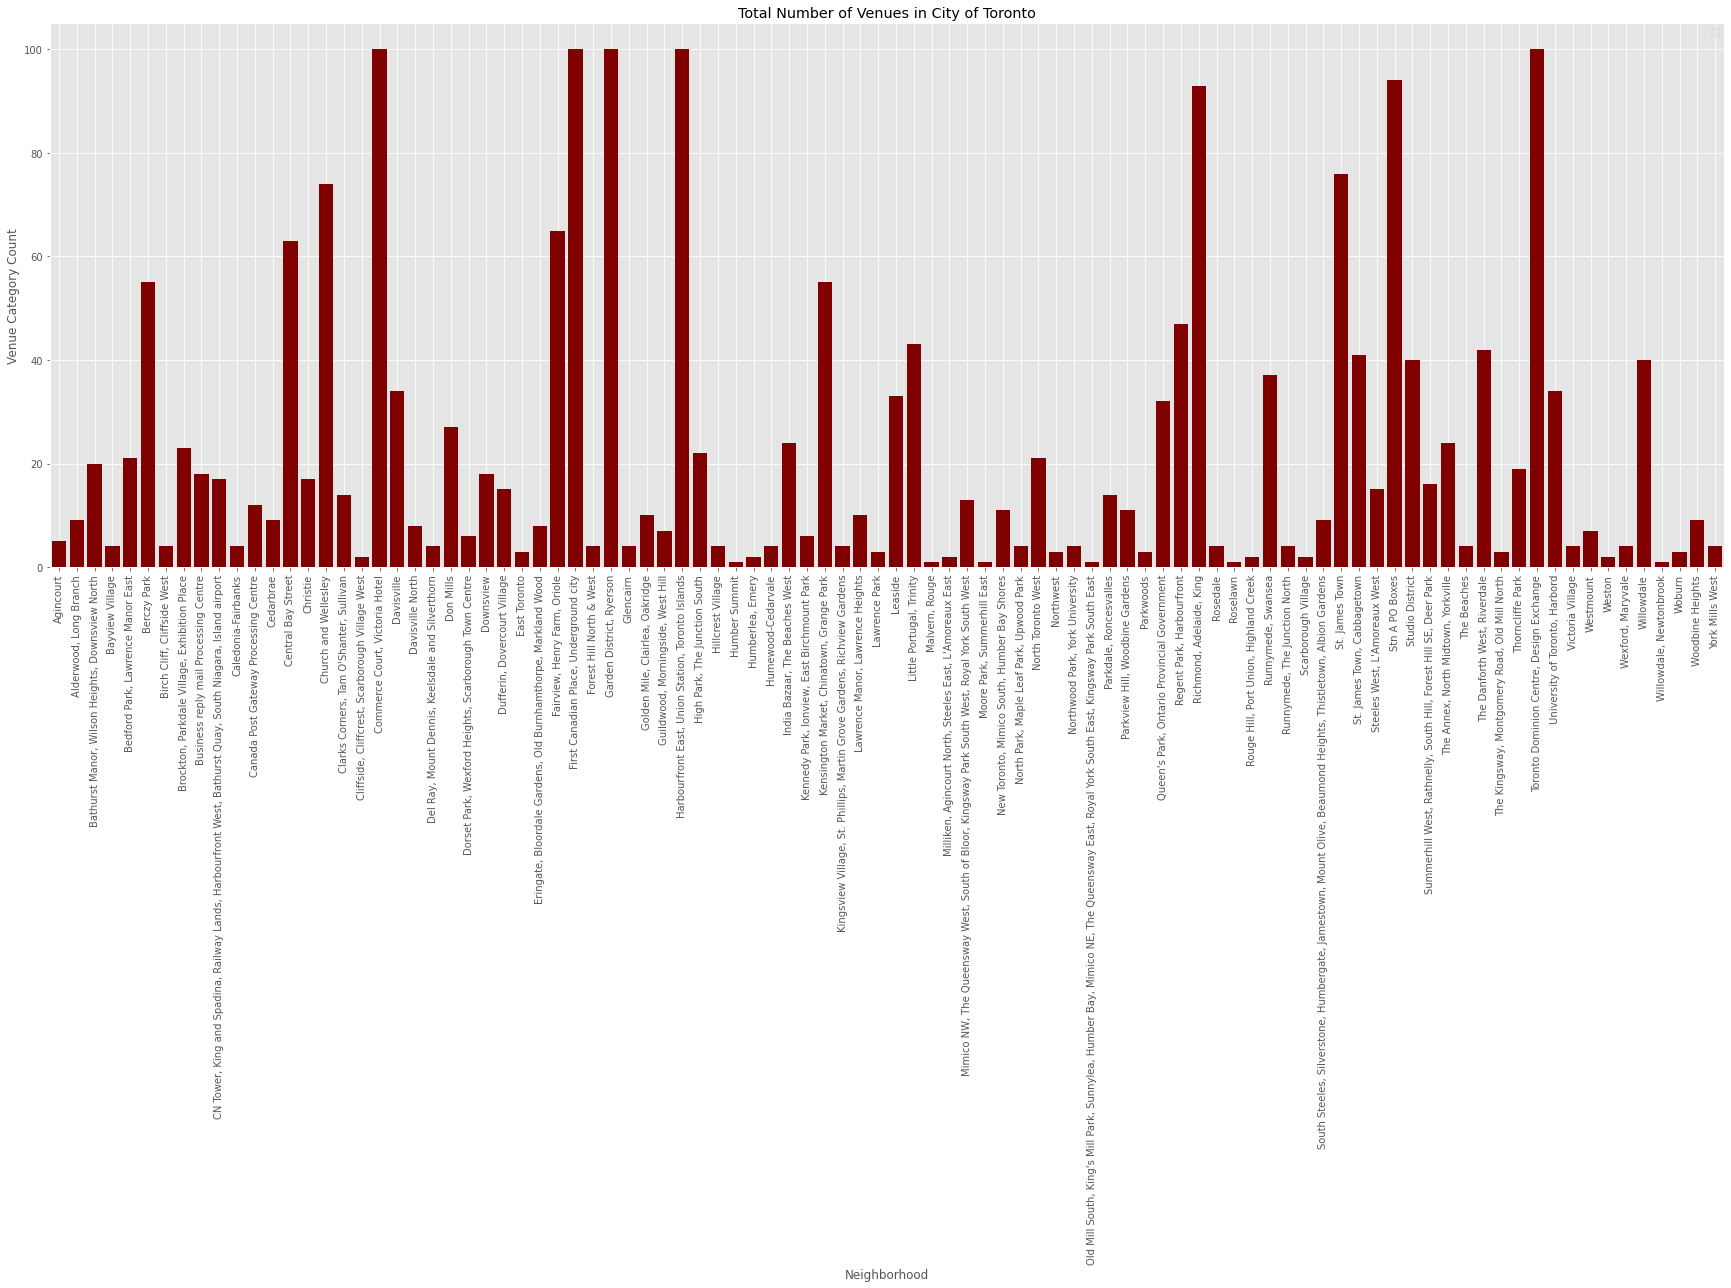

In [35]:
toronto_venues_grouped1 = toronto_venues_grouped.reset_index(drop=False)

plt.style.use('ggplot')
#--SETS UP THE PLOT
toronto_venues_grouped1.plot(kind='bar', figsize=(30, 10))
x = toronto_venues_grouped1['Neighborhood']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,toronto_venues_grouped1['Venue Category'] , color='maroon')
plt.xlabel("Neighborhood")
plt.ylabel("Venue Category Count")
plt.title("Total Number of Venues in City of Toronto")

plt.legend('') 
plt.xticks(x_pos, x)
#plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()

In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_final[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_final['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
dtoronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

American Restaurant  Aquarium  Art Gallery  Asian Restaurant  Bakery  Bank  \
0                    0         0            0                 0       0     0   
1                    0         0            0                 0       0     0   
2                    0         0            0                 0       0     0   
3                    0         0            0                 0       0     0   
4                    0         0            0                 0       0     0   

   Bar  Baseball Stadium  Basketball Stadium  Beer Bar  Bistro  Bookstore  \
0    0                 0                   0         0       0          0   
1    0                 0                   0         0       0          0   
2    0                 0                   0         0       0          0   
3    0                 0                   0         0       0          0   
4    0                 0                   0         0       0          0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  Building  \
0                     0               0        0                0         0   
1                     0               0        0                0         0   
2                     0               0        0                0         0   
3                     0               0        0                0         0   
4                     0               0        0                0         0   

   Burger Joint  Burrito Place  Café  Chinese Restaurant  Clothing Store  \
0             0              0     0                   0               1   
1             0              0     0                   0               0   
2             0              0     0                   0               0   
3             0              0     0                   0               0   
4             0              0     0                   0               0   

   Cocktail Bar  Coffee Shop  College Rec Center  Colombian Restaurant  \
0             0            0                   0                     0   
1             0            0                   0                     0   
2             0            0                   0                     0   
3             0            0                   0                     0   
4             0            0                   0                     0   

   Comic Shop  Concert Hall  Convention Center  Cosmetics Shop  Creperie  \
0           0             0                  0               0         0   
1           0             0                  0               0         0   
2           1             0                  0               0         0   
3           0             0                  0               0         0   
4           0             0                  0               0         0   

   Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Diner  \
0             0              0                 0             0      0   
1             0              0                 0             0      0   
2             0              0                 0             0      0   
3             0              0                 0             0      0   
4             0              0                 0             0      0   

   Discount Store  Electronics Store  Ethiopian Restaurant  Event Space  \
0               0                  0                     0            0   
1               0                  0                     0            0   
2               0                  0                     0            0   
3               0                  0                     0            0   
4               0                  0                     0            0   

   Fast Food Restaurant  Food Court  Food Truck  Fountain  French Restaurant  \
0                     0           0           0         0                  0   
1                     0           0           0         0                  0   
2                     0           0           0         0                  0   
3        

In [45]:
toronto_venues_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_venues_grouped

Neighborhood  American Restaurant  \
0                     Commerce Court, Victoria Hotel                 0.04   
1             First Canadian Place, Underground city                 0.03   
2                           Garden District, Ryerson                 0.00   
3  Harbourfront East, Union Station, Toronto Islands                 0.00   
4           Toronto Dominion Centre, Design Exchange                 0.03   

   Aquarium  Art Gallery  Asian Restaurant  Bakery  Bank   Bar  \
0      0.00         0.01              0.01    0.02  0.00  0.01   
1      0.00         0.01              0.03    0.01  0.00  0.02   
2      0.00         0.01              0.00    0.01  0.01  0.01   
3      0.05         0.01              0.00    0.01  0.01  0.02   
4      0.00         0.01              0.01    0.01  0.01  0.01   

   Baseball Stadium  Basketball Stadium  Beer Bar  Bistro  Bookstore  \
0              0.00                0.00      0.02    0.00       0.01   
1              0.00                0.00      0.02    0.00       0.01   
2              0.00                0.00      0.01    0.00       0.02   
3              0.02                0.01      0.01    0.01       0.00   
4              0.00                0.01      0.02    0.00       0.00   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  Building  \
0                  0.00            0.02     0.00             0.00      0.01   
1                  0.01            0.01     0.00             0.00      0.01   
2                  0.00            0.00     0.00             0.03      0.00   
3                  0.00            0.00     0.03             0.01      0.00   
4                  0.00            0.01     0.00             0.00      0.00   

   Burger Joint  Burrito Place  Café  Chinese Restaurant  Clothing Store  \
0          0.01           0.00  0.07                0.00            0.00   
1          0.01           0.00  0.08                0.00            0.00   
2          0.01           0.01  0.03                0.01            0.09   
3          0.00           0.00  0.04                0.01            0.00   
4          0.00           0.01  0.07                0.01            0.01   

   Cocktail Bar  Coffee Shop  College Rec Center  Colombian Restaurant  \
0          0.02         0.11                0.00                  0.00   
1          0.00         0.10                0.00                  0.01   
2          0.00         0.08                0.01                  0.00   
3          0.00         0.13                0.00                  0.00   
4          0.00         0.10                0.00                  0.00   

   Comic Shop  Concert Hall  Convention Center  Cosmetics Shop  Creperie  \
0        0.00          0.01               0.00            0.00      0.01   
1        0.00          0.02               0.00            0.00      0.00   
2        0.01          0.00               0.00            0.03      0.00   
3        0.00          0.00               0.01            0.00      0.00   
4        0.00          0.02               0.00            0.00      0.00   

   Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Diner  \
0          0.00           0.03              0.00          0.00   0.00   
1          0.00           0.03              0.00          0.00   0.00   
2          0.00           0.00              0.01          0.01   0.02   
3          0.01           0.01              0.01          0.01   0.00   
4          0.00           0.02              0.00          0.00   0.00   

   Discount Store  Electronics Store  Ethiopian Restaurant  Event Space  \
0            0.00               0.00                  0.00         0.00   
1            0.00               0.00                  0.00         0.00   
2            0.00               0.01                  0.01         0.00   
3            0.01               0.00                  0.00         0.01   
4            0.00               0.00                  0.00         0.00   

   Fast Food Restaurant

In [38]:
toronto_venues_mms = toronto_venues_grouped.drop('Neighborhood',axis=1,inplace=True)

mms = MinMaxScaler()
mms.fit(toronto_venues_grouped)
data_transformed = mms.transform(toronto_venues_grouped)

In [39]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

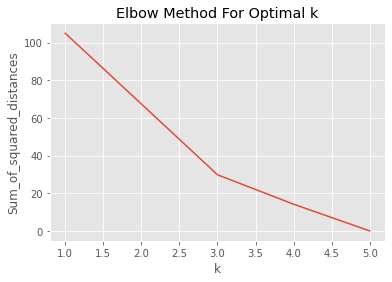

In [40]:
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [46]:
# set number of clusters
# There is a prominent crook seen in the elbow method graph. Since there are five neighborhoods only being /
# analyzed, there is the danger of overfitting if the cluster size is closer to the limit of 5.

kclusters = 3 

toronto_grouped_clustering = toronto_venues_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 1, 2, 0], dtype=int32)

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
num_top_venues = 10 #10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
   
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_venues_grouped['Neighborhood']

for ind in np.arange(toronto_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                     Commerce Court, Victoria Hotel           Coffee Shop   
1             First Canadian Place, Underground city           Coffee Shop   
2                           Garden District, Ryerson        Clothing Store   
3  Harbourfront East, Union Station, Toronto Islands           Coffee Shop   
4           Toronto Dominion Centre, Design Exchange           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
0            Restaurant                  Café                      Hotel   
1                  Café   Japanese Restaurant                      Hotel   
2           Coffee Shop       Bubble Tea Shop  Middle Eastern Restaurant   
3              Aquarium                  Café                      Hotel   
4                  Café                 Hotel                 Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0   American Restaurant                   Gym   Japanese Restaurant   
1                   Gym            Restaurant   American Restaurant   
2                  Café            Restaurant   Japanese Restaurant   
3        Scenic Lookout            Restaurant    Italian Restaurant   
4   American Restaurant   Japanese Restaurant    Italian Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0    Italian Restaurant    Seafood Restaurant          Deli / Bodega  
1            Steakhouse           Salad Place     Seafood Restaurant  
2        Cosmetics Shop    Italian Restaurant                  Hotel  
3   Sporting Goods Shop               Brewery    Fried Chicken Joint  
4           Salad Place    Seafood Restaurant             Steakhouse

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_venues_final

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(3) # check the last columns!


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Garden District, Ryerson              43.657162              -79.378937   
1  Garden District, Ryerson              43.657162              -79.378937   
2  Garden District, Ryerson              43.657162              -79.378937   

                 Venue  Venue Latitude  Venue Longitude  Venue Category  \
0          UNIQLO ユニクロ       43.655910       -79.380641  Clothing Store   
1            DAVIDsTEA       43.656973       -79.381040        Tea Room   
2  Silver Snail Comics       43.657031       -79.381403      Comic Shop   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               1        Clothing Store           Coffee Shop   
1               1        Clothing Store           Coffee Shop   
2               1        Clothing Store           Coffee Shop   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
0       Bubble Tea Shop  Middle Eastern Restaurant                  Café   
1       Bubble Tea Shop  Middle Eastern Restaurant                  Café   
2       Bubble Tea Shop  Middle Eastern Restaurant                  Café   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Restaurant   Japanese Restaurant        Cosmetics Shop   
1            Restaurant   Japanese Restaurant        Cosmetics Shop   
2            Restaurant   Japanese Restaurant        Cosmetics Shop   

  9th Most Common Venue 10th Most Common Venue  
0    Italian Restaurant                  Hotel  
1    Italian Restaurant                  Hotel  
2    Italian Restaurant                  Hotel

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood  Venue Longitude  \
200  Toronto Dominion Centre, Design Exchange       -79.381320   
201  Toronto Dominion Centre, Design Exchange       -79.379989   
202  Toronto Dominion Centre, Design Exchange       -79.378745   
203  Toronto Dominion Centre, Design Exchange       -79.380605   
204  Toronto Dominion Centre, Design Exchange       -79.380936   
205  Toronto Dominion Centre, Design Exchange       -79.381921   
206  Toronto Dominion Centre, Design Exchange       -79.381376   
207  Toronto Dominion Centre, Design Exchange       -79.379515   
208  Toronto Dominion Centre, Design Exchange       -79.380145   
209  Toronto Dominion Centre, Design Exchange       -79.382253   
210  Toronto Dominion Centre, Design Exchange       -79.380127   
211  Toronto Dominion Centre, Design Exchange       -79.381508   
212  Toronto Dominion Centre, Design Exchange       -79.382058   
213  Toronto Dominion Centre, Design Exchange       -79.380415   
214  Toronto Dominion Centre, Design Exchange       -79.384332   
215  Toronto Dominion Centre, Design Exchange       -79.378782   
216  Toronto Dominion Centre, Design Exchange       -79.383199   
217  Toronto Dominion Centre, Design Exchange       -79.379597   
218  Toronto Dominion Centre, Design Exchange       -79.382919   
219  Toronto Dominion Centre, Design Exchange       -79.379588   
220  Toronto Dominion Centre, Design Exchange       -79.380104   
221  Toronto Dominion Centre, Design Exchange       -79.377323   
222  Toronto Dominion Centre, Design Exchange       -79.379608   
223  Toronto Dominion Centre, Design Exchange       -79.381671   
224  Toronto Dominion Centre, Design Exchange       -79.385367   
225  Toronto Dominion Centre, Design Exchange       -79.385979   
226  Toronto Dominion Centre, Design Exchange       -79.385111   
227  Toronto Dominion Centre, Design Exchange       -79.383065   
228  Toronto Dominion Centre, Design Exchange       -79.378599   
229  Toronto Dominion Centre, Design Exchange       -79.378313   
230  Toronto Dominion Centre, Design Exchange       -79.384103   
231  Toronto Dominion Centre, Design Exchange       -79.377295   
232  Toronto Dominion Centre, Design Exchange       -79.381613   
233  Toronto Dominion Centre, Design Exchange       -79.386541   
234  Toronto Dominion Centre, Design Exchange       -79.383053   
235  Toronto Dominion Centre, Design Exchange       -79.379181   
236  Toronto Dominion Centre, Design Exchange       -79.379393   
237  Toronto Dominion Centre, Design Exchange       -79.379573   
238  Toronto Dominion Centre, Design Exchange       -79.380574   
239  Toronto Dominion Centre, Design Exchange       -79.379040   
240  Toronto Dominion Centre, Design Exchange       -79.381956   
241  Toronto Dominion Centre, Design Exchange       -79.378765   
242  Toronto Dominion Centre, Design Exchange       -79.381555   
243  Toronto Dominion Centre, Design Exchange       -79.380892   
244  Toronto Dominion Centre, Design Exchange       -79.385156   
245  Toronto Dominion Centre, Design Exchange       -79.380184   
246  Toronto Dominion Centre, Design Exchange       -79.377237   
247  Toronto Dominion Centre, Design Exchange       -79.386557   
248  Toronto Dominion Centre, Design Exchange       -79.380999   
249  Toronto Dominion Centre, Design Exchange       -79.387089   
250  Toronto Dominion Centre, Design Exchange       -79.383385   
251  Toronto Dominion Centre, Design Exchange       -79.382081   
252  Toronto Dominion Centre, Design Exchange       -79.380164   
253  Toronto Dominion Centre, Design Exchange       -79.376334   
254  Toronto Dominion Centre, Design Exchange       -79.387128   
255  Toronto Dominion Centre, Design Exchange       -79.384141   
256  Toronto Dominion Centre, Design Exchange       -79.379422   
257  Toronto Dominion Centre, Design Exchange       -79.383412   
258  Toronto Dominion Centre, Design Exchange       -79.379159   
259  Toronto Dominion Centre, Design Exchange       -79.378769   
260  To

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood  Venue Longitude              Venue Category  \
0   Garden District, Ryerson       -79.380641              Clothing Store   
1   Garden District, Ryerson       -79.381040                    Tea Room   
2   Garden District, Ryerson       -79.381403                  Comic Shop   
3   Garden District, Ryerson       -79.379768                     Theater   
4   Garden District, Ryerson       -79.380495                       Plaza   
5   Garden District, Ryerson       -79.376073                        Café   
6   Garden District, Ryerson       -79.378343               Burrito Place   
7   Garden District, Ryerson       -79.379276                 Music Venue   
8   Garden District, Ryerson       -79.381385                        Café   
9   Garden District, Ryerson       -79.381620             Thai Restaurant   
10  Garden District, Ryerson       -79.380870                 Coffee Shop   
11  Garden District, Ryerson       -79.382177                  Steakhouse   
12  Garden District, Ryerson       -79.380910          Mexican Restaurant   
13  Garden District, Ryerson       -79.381949              Sandwich Place   
14  Garden District, Ryerson       -79.381011           Electronics Store   
15  Garden District, Ryerson       -79.378315                        Café   
16  Garden District, Ryerson       -79.380677               Shopping Mall   
17  Garden District, Ryerson       -79.379460                 Art Gallery   
18  Garden District, Ryerson       -79.377586            Ramen Restaurant   
19  Garden District, Ryerson       -79.381929                  Restaurant   
20  Garden District, Ryerson       -79.381015         Sporting Goods Shop   
21  Garden District, Ryerson       -79.380248               Tanning Salon   
22  Garden District, Ryerson       -79.380853                Burger Joint   
23  Garden District, Ryerson       -79.381689   Middle Eastern Restaurant   
24  Garden District, Ryerson       -79.379199                       Diner   
25  Garden District, Ryerson       -79.380889        Fast Food Restaurant   
26  Garden District, Ryerson       -79.378507                     Theater   
27  Garden District, Ryerson       -79.379296          College Rec Center   
28  Garden District, Ryerson       -79.374110                       Hotel   
29  Garden District, Ryerson       -79.383684                 Coffee Shop   
30  Garden District, Ryerson       -79.382949                         Bar   
31  Garden District, Ryerson       -79.381878     New American Restaurant   
32  Garden District, Ryerson       -79.383761  Modern European Restaurant   
33  Garden District, Ryerson       -79.382586                         Spa   
34  Garden District, Ryerson       -79.378891         Japanese Restaurant   
35  Garden District, Ryerson       -79.380245   Middle Eastern Restaurant   
36  Garden District, Ryerson       -79.383524                   Gastropub   
37  Garden District, Ryerson       -79.378880            Ramen Restaurant   
38  Garden District, Ryerson       -79.380696                   Bookstore   
39  Garden District, Ryerson       -79.380945                    Tea Room   
40  Garden District, Ryerson       -79.380508                  Restaurant   
41  Garden District, Ryerson       -79.380400              Cosmetics Shop   
42  Garden District, Ryerson       -79.380966              Clothing Store   
43  Garden District, Ryerson       -79.380740                      Bakery   
44  Garden District, Ryerson       -79.376898                        Lake   
45  Garden District, Ryerson       -79.381661                   Bookstore   
46  Garden District, Ryerson       -79.382040             Bubble Tea Shop   
47  Garden District, Ryerson       -79.374221                      Lounge   
48  Garden District, Ryerson       -79.380120              Cosmetics Shop   
49  Garden District, Ryerson       -79.377078        Ethiopian Restaurant   
50  Garden District, Ryerson       -79.378919                 Coffee Shop   
51  Garden D

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

Neighborhood  Venue Longitude  \
100  Harbourfront East, Union Station, Toronto Islands       -79.380688   
101  Harbourfront East, Union Station, Toronto Islands       -79.384279   
102  Harbourfront East, Union Station, Toronto Islands       -79.380892   
103  Harbourfront East, Union Station, Toronto Islands       -79.379665   
104  Harbourfront East, Union Station, Toronto Islands       -79.383190   
105  Harbourfront East, Union Station, Toronto Islands       -79.382081   
106  Harbourfront East, Union Station, Toronto Islands       -79.380184   
107  Harbourfront East, Union Station, Toronto Islands       -79.383949   
108  Harbourfront East, Union Station, Toronto Islands       -79.382528   
109  Harbourfront East, Union Station, Toronto Islands       -79.381393   
110  Harbourfront East, Union Station, Toronto Islands       -79.378395   
111  Harbourfront East, Union Station, Toronto Islands       -79.382096   
112  Harbourfront East, Union Station, Toronto Islands       -79.380068   
113  Harbourfront East, Union Station, Toronto Islands       -79.380918   
114  Harbourfront East, Union Station, Toronto Islands       -79.381441   
115  Harbourfront East, Union Station, Toronto Islands       -79.382463   
116  Harbourfront East, Union Station, Toronto Islands       -79.379606   
117  Harbourfront East, Union Station, Toronto Islands       -79.377531   
118  Harbourfront East, Union Station, Toronto Islands       -79.384650   
119  Harbourfront East, Union Station, Toronto Islands       -79.380999   
120  Harbourfront East, Union Station, Toronto Islands       -79.383456   
121  Harbourfront East, Union Station, Toronto Islands       -79.379040   
122  Harbourfront East, Union Station, Toronto Islands       -79.383885   
123  Harbourfront East, Union Station, Toronto Islands       -79.384992   
124  Harbourfront East, Union Station, Toronto Islands       -79.380470   
125  Harbourfront East, Union Station, Toronto Islands       -79.380688   
126  Harbourfront East, Union Station, Toronto Islands       -79.379159   
127  Harbourfront East, Union Station, Toronto Islands       -79.383257   
128  Harbourfront East, Union Station, Toronto Islands       -79.383199   
129  Harbourfront East, Union Station, Toronto Islands       -79.386252   
130  Harbourfront East, Union Station, Toronto Islands       -79.383749   
131  Harbourfront East, Union Station, Toronto Islands       -79.387089   
132  Harbourfront East, Union Station, Toronto Islands       -79.381994   
133  Harbourfront East, Union Station, Toronto Islands       -79.383809   
134  Harbourfront East, Union Station, Toronto Islands       -79.377552   
135  Harbourfront East, Union Station, Toronto Islands       -79.387038   
136  Harbourfront East, Union Station, Toronto Islands       -79.385930   
137  Harbourfront East, Union Station, Toronto Islands       -79.387150   
138  Harbourfront East, Union Station, Toronto Islands       -79.381540   
139  Harbourfront East, Union Station, Toronto Islands       -79.387182   
140  Harbourfront East, Union Station, Toronto Islands       -79.385925   
141  Harbourfront East, Union Station, Toronto Islands       -79.381376   
142  Harbourfront East, Union Station, Toronto Islands       -79.380378   
143  Harbourfront East, Union Station, Toronto Islands       -79.379965   
144  Harbourfront East, Union Station, Toronto Islands       -79.383065   
145  Harbourfront East, Union Station, Toronto Islands       -79.382299   
146  Harbourfront East, Union Station, Toronto Islands       -79.385884   
147  Harbourfront East, Union Station, Toronto Islands       -79.386340   
148  Harbourfront East, Union Station, Toronto Islands       -79.380415   
149  Harbourfront East, Union Station, Toronto Islands       -79.380355   
150  Harbourfront East, Union Station, Toronto Islands       -79.380546   
151  Harbourfront East, Union Station, Toronto Islands       -79.381763   
152  Harbourfront East, Union Station, Toronto Islands       -79.38

### Analyzing the Clustering information

From the clustered data, the following can be understood:

The number of clusters are two, 0 and 1.

All five neighborhoods chosen for having the maximum number of venues are clustered in these two clusters. 
Cluster 0 and Cluster 1.

Cluster 0 has the following neighborhoods

Toronto Dominion Centre, Design Centre

Commerce Court, Victoria Hotel

First Canadian Place, Underground city

Cluster 1 has the following neighborhoods

Garden District, Ryerson

Cluster 2 has the following neighborhoods

Harbourfront east, Union Station, Toronto Islands

The cluster data shows 

#### In neighborhoods in Cluster 0 have the following in common

##### The top 10 venues have at least eight venues related to food. 

##### In the one neighborhood in Cluster 1 which is located further away from Cluster 0

##### There is only one restaurant in the top five venues The first venue is a clothing store. A total of six food venues in the top 10.

#### In Cluster 2, there are five food venues in the top 10.

#### Clearly, the clustering process has shown that Cluster 0 is where one must concentrate to open an eatery!

           - 

### GET THE VENUES THAT ARE EATERIES ONLY

The number of venues retrieved from the dataset are a mix of eateries, entertainment and other organization /institutions. Since the venues of interest are only eateries, the other types must be deleted. 

Therefore the data must be scrubbed to obtain just the eatery venues. Scrubbing involved deleting the various venues that were clearly not eateries like trail, park, bar, etc. The quick and easy way of dropping those were to write to a csv and deleting the rows for each of the five neighborhoods, then reading back the cleaned dataset.

In [54]:
toronto_venues_prefer = toronto_venues_final

#Lets extract each neighborhood separately
#first - Harbourfront
venue1 = 'Harbourfront East'
neighborhood_1 = toronto_venues_prefer[toronto_venues_prefer.Neighborhood.str.contains(venue1, case = False)]

#second - Toronto
venue2 = 'Toronto Dominion'
neighborhood_2 = toronto_venues_prefer[toronto_venues_prefer.Neighborhood.str.contains(venue2, case = False)]

#third - First Canadian
venue3 = 'First Canadian'
neighborhood_3 = toronto_venues_prefer[toronto_venues_prefer.Neighborhood.str.contains(venue3, case = False)]

#fourth - Garden district
venue4 = 'Garden District'
neighborhood_4 = toronto_venues_prefer[toronto_venues_prefer.Neighborhood.str.contains(venue4, case = False)]

#fifth - Commerce Place
venue5 = 'Commerce Court'
neighborhood_5 = toronto_venues_prefer[toronto_venues_prefer.Neighborhood.str.contains(venue5, case = False)]


### PLOT THE NUMBER (COUNT) OF THE DIFFERENT EATERIES FOR THE FIVE NEIGHBORHOODS
The dataset with the eateries and count are read in from a 'csv' for each of the five neighborhoods.

In [55]:
#GET THE COUNT OF UNIQUE CATEGORIES IN Harbourfront East, Union Station, Toronto Islands Neighborhoods
nb1_venue = neighborhood_1['Venue Category'].value_counts()
nb1_venue = nb1_venue.to_frame()
nb1_venue.reset_index(inplace=True)
nb1_venue = nb1_venue.rename(columns={'index':'Venue Category','Venue Category':'Count'})
nb1_venue.sort_values('Venue Category',inplace=True)
nb1_venue.reset_index(drop=True,inplace=True)

In [56]:
path = '/home/vision/Documents/Coursera/Data_Science/Applied_Capstone/Jupyter_Notebooks/Capstone/'

In [57]:
nb1_venue = pd.read_csv(path+'eatery_nb1_venue_count.csv')
totalv1 = nb1_venue['Count'].sum()
print("Total number of venues in the neighborhood: "+str(totalv1))
nb1_venue

Total number of venues in the neighborhood: 43


Venue Category  Count
0                          Bistro      1
1                            Café      4
2              Chinese Restaurant      1
3                     Coffee Shop     13
4                    Dessert Shop      1
5             Fried Chicken Joint      3
6                  Ice Cream Shop      1
7               Indian Restaurant      1
8              Italian Restaurant      3
9             Japanese Restaurant      1
10        New American Restaurant      1
11                    Pizza Place      2
12                     Restaurant      3
13                    Salad Place      1
14                 Sandwich Place      1
15             Seafood Restaurant      1
16                     Sports Bar      1
17                     Steakhouse      1
18               Sushi Restaurant      1
19                       Tea Room      1
20  Vegetarian / Vegan Restaurant      1

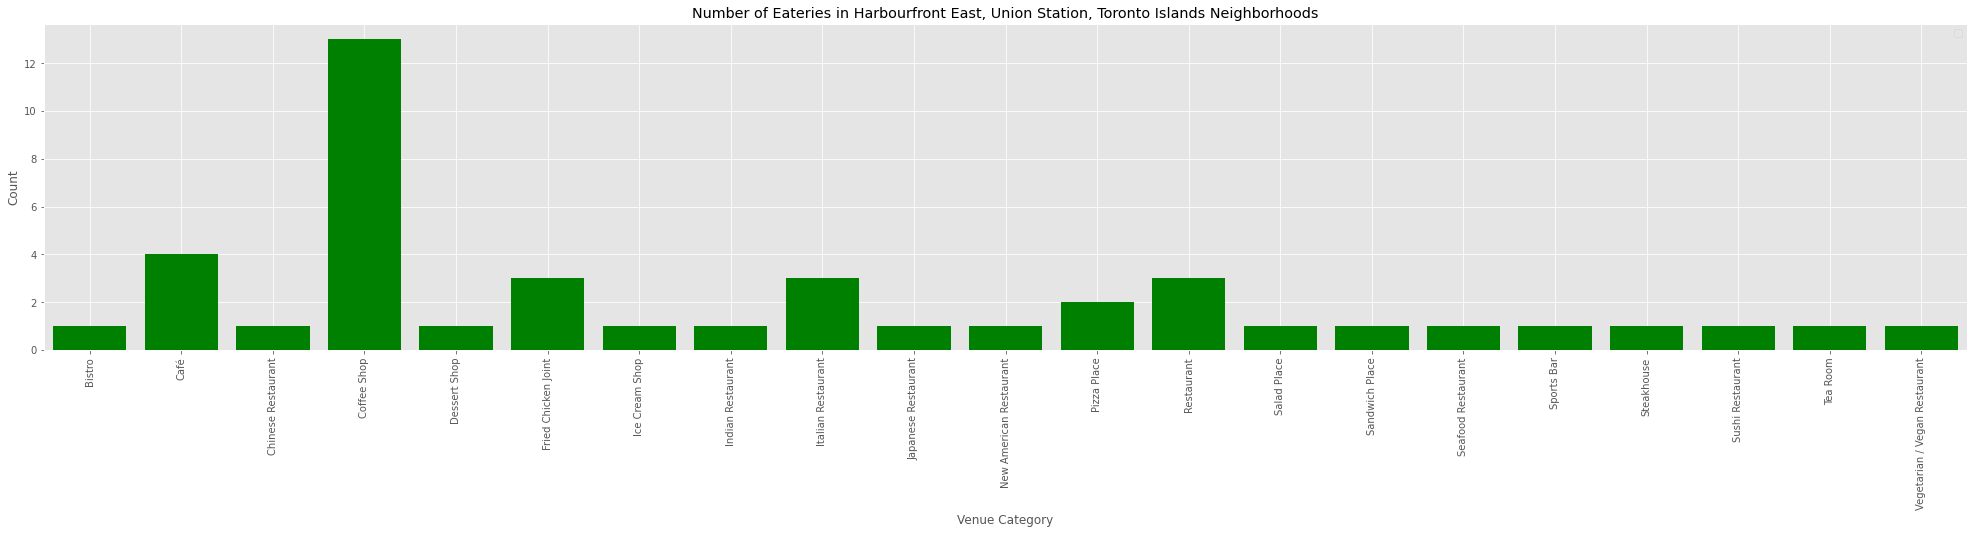

In [58]:
plt.style.use('ggplot')

nb1_venue.plot(kind='bar', figsize=(30, 10))
x = nb1_venue['Venue Category']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,nb1_venue['Count'] , color='green')
plt.xlabel("Venue Category")
plt.ylabel("Count")

plt.title("Number of Eateries in Harbourfront East, Union Station, Toronto Islands Neighborhoods")

plt.legend('') 
plt.xticks(x_pos, x)

plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()


In [59]:
#GET THE COUNT OF UNIQUE CATEGORIES IN Toronto Dominion Centre, Design Exchange Neighborhoods
nb2_venue = neighborhood_2['Venue Category'].value_counts()
nb2_venue = nb2_venue.to_frame()
nb2_venue.reset_index(inplace=True)
nb2_venue = nb2_venue.rename(columns={'index':'Venue Category','Venue Category':'Count'})
nb2_venue.sort_values('Venue Category',inplace=True)
nb2_venue.reset_index(drop=True,inplace=True)

In [60]:
nb2_venue = pd.read_csv(path+'eatery_nb2_venue_count.csv')
totalv2 = nb2_venue['Count'].sum()
print("Total number of venues in the neighborhood: "+str(totalv2))
nb2_venue

Total number of venues in the neighborhood: 64


Venue Category  Count
0             American Restaurant      3
1                Asian Restaurant      2
2                  Breakfast Spot      1
3                   Burrito Place      1
4                            Café      7
5              Chinese Restaurant      1
6                     Coffee Shop     10
7                   Deli / Bodega      2
8            Fast Food Restaurant      1
9                      Food Court      1
10              French Restaurant      1
11                      Gastropub      2
12         Gluten-free Restaurant      1
13               Greek Restaurant      1
14                 Ice Cream Shop      1
15             Italian Restaurant      3
16            Japanese Restaurant      3
17        New American Restaurant      1
18                    Pizza Place      1
19                            Pub      1
20                     Restaurant      5
21                    Salad Place      3
22                 Sandwich Place      1
23             Seafood Restaurant      3
24                     Steakhouse      2
25               Sushi Restaurant      2
26                     Taco Place      1
27                       Tea Room      2
28  Vegetarian / Vegan Restaurant      1

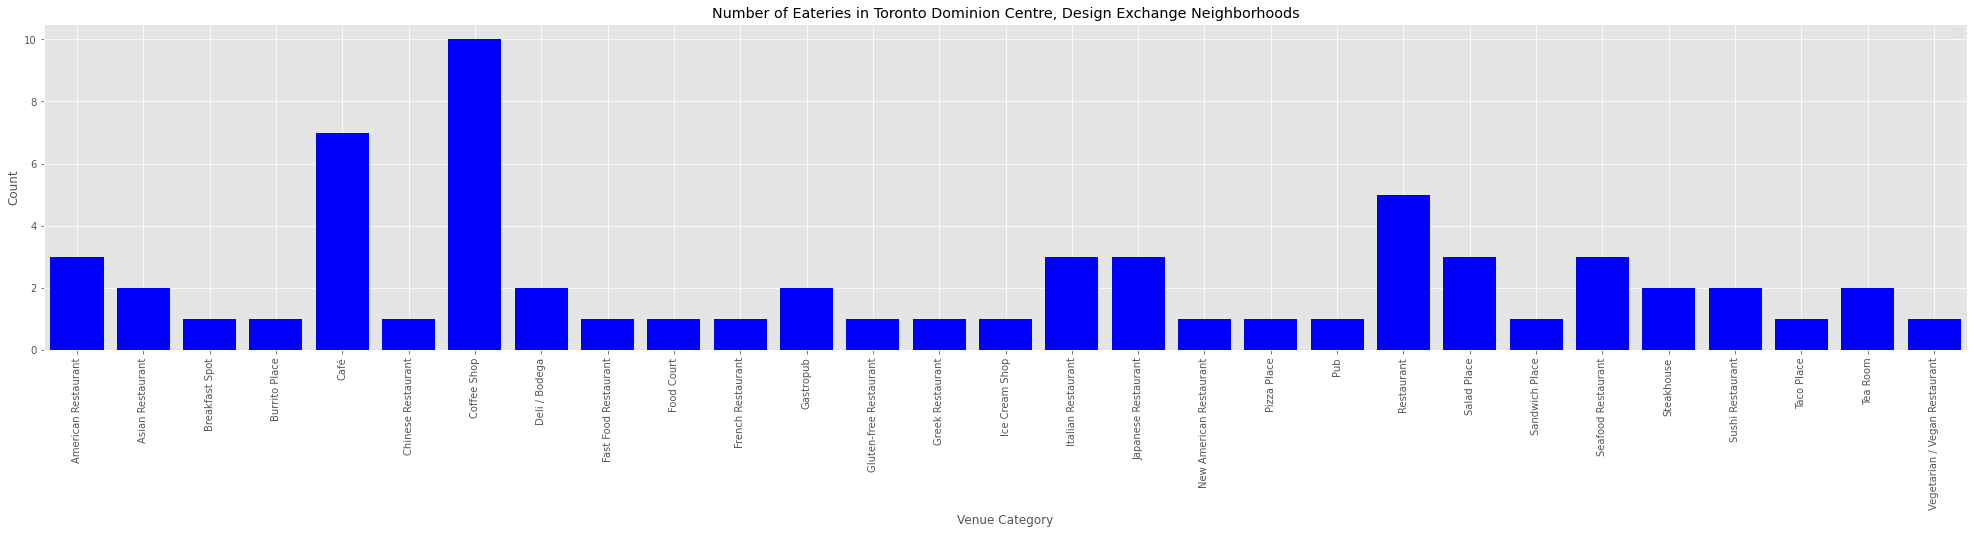

In [61]:
plt.style.use('ggplot')

nb2_venue.plot(kind='bar', figsize=(30, 10))
x = nb2_venue['Venue Category']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,nb2_venue['Count'] , color='blue')
plt.xlabel("Venue Category")
plt.ylabel("Count")
plt.title("Number of Eateries in Toronto Dominion Centre, Design Exchange Neighborhoods")

plt.legend('') 
plt.xticks(x_pos, x)

plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()


In [62]:
#GET THE COUNT OF UNIQUE CATEGORIES IN First Canadian Place, Underground City
nb3_venue = neighborhood_3['Venue Category'].value_counts()
nb3_venue = nb3_venue.to_frame()
nb3_venue.reset_index(inplace=True)
nb3_venue = nb3_venue.rename(columns={'index':'Venue Category','Venue Category':'Count'})
nb3_venue.sort_values('Venue Category',inplace=True)
nb3_venue.reset_index(drop=True,inplace=True)

In [63]:
nb3_venue = pd.read_csv(path+'eatery_nb3_venue_count.csv')
totalv3 = nb3_venue['Count'].sum()
print("Total number of venues in the neighborhood: "+str(totalv3))
nb3_venue

Total number of venues in the neighborhood: 70


Venue Category  Count
0             American Restaurant      3
1                Asian Restaurant      3
2            Brazilian Restaurant      1
3                  Breakfast Spot      1
4                    Burger Joint      1
5                            Café      8
6                     Coffee Shop     10
7            Colombian Restaurant      1
8                   Deli / Bodega      3
9            Fast Food Restaurant      1
10                     Food Court      1
11                      Gastropub      2
12         Gluten-free Restaurant      1
13               Greek Restaurant      1
14                 Ice Cream Shop      1
15             Italian Restaurant      1
16            Japanese Restaurant      4
17       Mediterranean Restaurant      1
18        New American Restaurant      1
19                    Pizza Place      2
20                          Plaza      1
21                            Pub      1
22                     Restaurant      4
23                    Salad Place      3
24                 Sandwich Place      1
25             Seafood Restaurant      3
26                     Steakhouse      3
27               Sushi Restaurant      2
28                       Tea Room      2
29                Thai Restaurant      2
30  Vegetarian / Vegan Restaurant      1

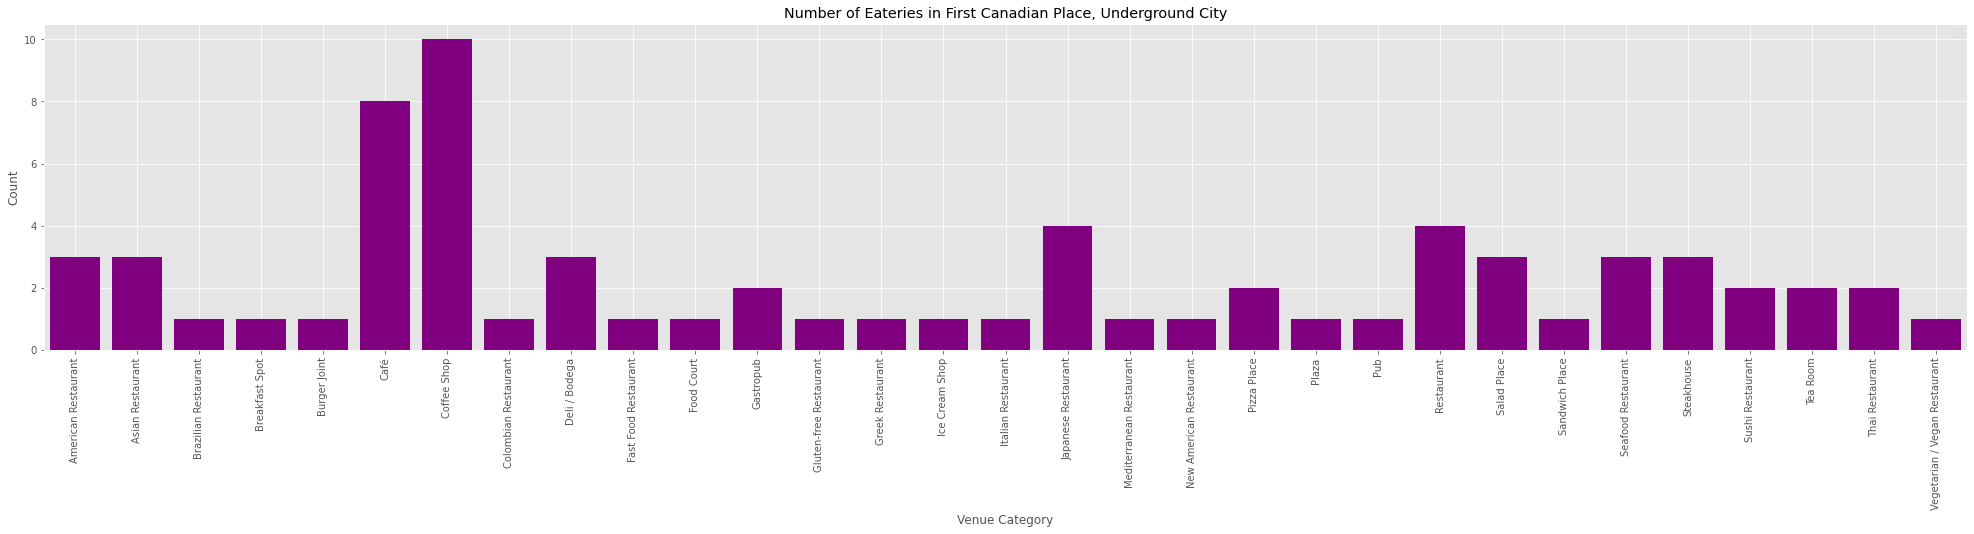

In [64]:
plt.style.use('ggplot')

nb3_venue.plot(kind='bar', figsize=(30, 10))
x = nb3_venue['Venue Category']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,nb3_venue['Count'] , color='purple')
plt.xlabel("Venue Category")
plt.ylabel("Count")
plt.title("Number of Eateries in First Canadian Place, Underground City")

plt.legend('') 
plt.xticks(x_pos, x)

plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()


In [65]:
#GET THE COUNT OF UNIQUE CATEGORIES IN Garden District, Ryerson
nb4_venue = neighborhood_4['Venue Category'].value_counts()
nb4_venue = nb4_venue.to_frame()
nb4_venue.reset_index(inplace=True)
nb4_venue = nb4_venue.rename(columns={'index':'Venue Category','Venue Category':'Count'})
nb4_venue.sort_values('Venue Category',inplace=True)
nb4_venue.reset_index(drop=True,inplace=True)

In [66]:
nb4_venue = pd.read_csv(path+'eatery_nb4_venue_count.csv')
totalv4 = nb4_venue['Count'].sum()
print("Total number of venues in the neighborhood: "+str(totalv4))
nb4_venue

Total number of venues in the neighborhood: 49


Venue Category  Count
0                 Burger Joint      1
1                Burrito Place      1
2                         Café      3
3           Chinese Restaurant      1
4                  Coffee Shop      8
5                 Dessert Shop      1
6                        Diner      2
7         Ethiopian Restaurant      1
8         Fast Food Restaurant      2
9                    Gastropub      1
10          Italian Restaurant      3
11         Japanese Restaurant      3
12          Mexican Restaurant      1
13   Middle Eastern Restaurant      3
14          Miscellaneous Shop      1
15  Modern European Restaurant      1
16     New American Restaurant      1
17                 Pizza Place      1
18               Poutine Place      1
19                         Pub      1
20            Ramen Restaurant      2
21                  Restaurant      3
22              Sandwich Place      1
23          Seafood Restaurant      1
24                  Steakhouse      1
25                    Tea Room      2
26             Thai Restaurant      1
27       Vietnamese Restaurant      1

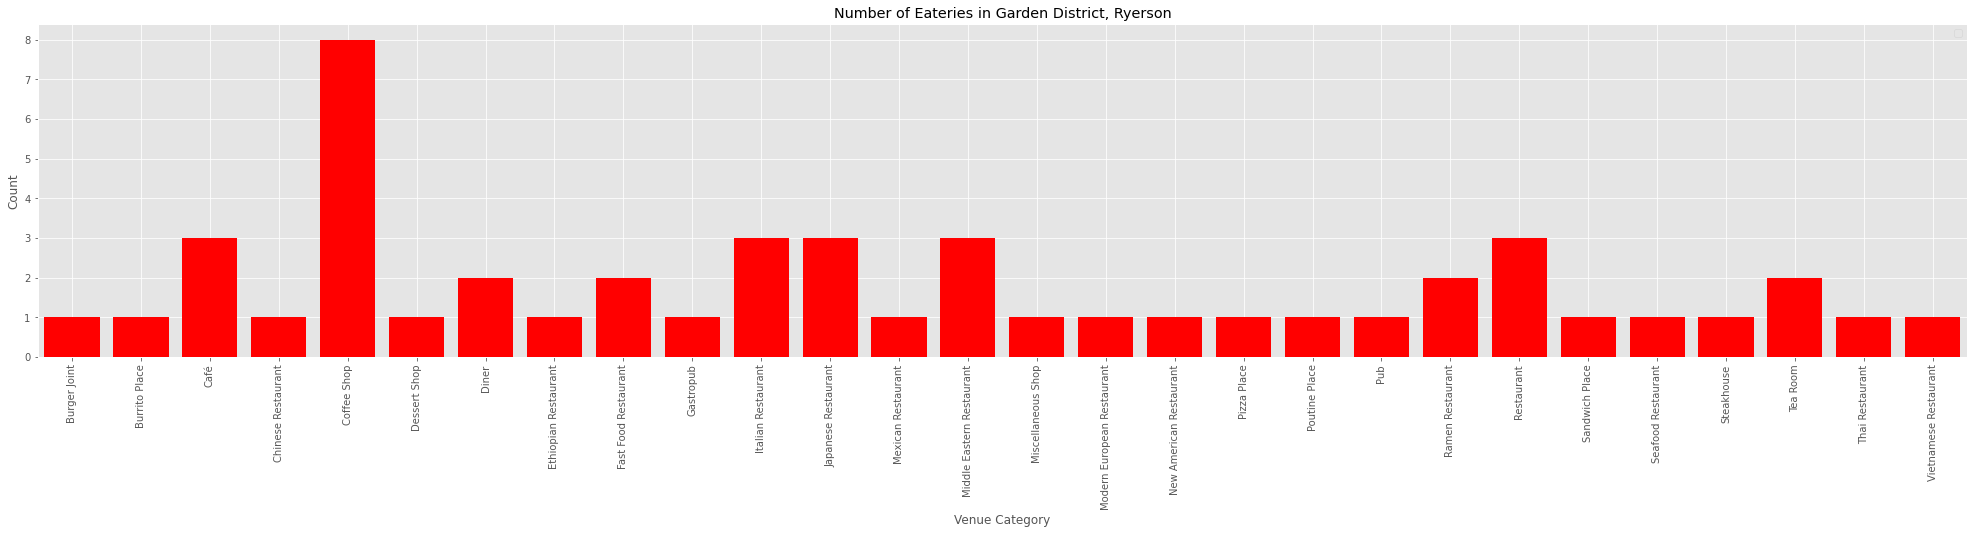

In [67]:
plt.style.use('ggplot')

nb4_venue.plot(kind='bar', figsize=(30, 10))
x = nb4_venue['Venue Category']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,nb4_venue['Count'] , color='red')
plt.xlabel("Venue Category")
plt.ylabel("Count")
plt.title("Number of Eateries in Garden District, Ryerson")

plt.legend('') 
plt.xticks(x_pos, x)

plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()


In [68]:
#GET THE COUNT OF UNIQUE CATEGORIES IN Commerce Court, Victoria Hotel
nb5_venue = neighborhood_5['Venue Category'].value_counts()
nb5_venue = nb5_venue.to_frame()
nb5_venue.reset_index(inplace=True)
nb4_venue = nb5_venue.rename(columns={'index':'Venue Category','Venue Category':'Count'})
nb5_venue.sort_values('Venue Category',inplace=True)
nb5_venue.reset_index(drop=True,inplace=True)

In [69]:
nb5_venue = pd.read_csv(path+'eatery_nb5_venue_count.csv')
totalv5 = nb5_venue['Count'].sum()
print("Total number of venues in the neighborhood: "+str(totalv5))
nb5_venue

Total number of venues in the neighborhood: 69


Venue Category  Count
0             American Restaurant      4
1                Asian Restaurant      1
2                  Breakfast Spot      2
3                    Burger Joint      1
4                            Café      7
5                    Cocktail Bar      2
6                     Coffee Shop     11
7                        Creperie      1
8                   Deli / Bodega      3
9            Fast Food Restaurant      1
10                     Food Court      1
11                     Food Truck      1
12              French Restaurant      1
13                      Gastropub      2
14         Gluten-free Restaurant      1
15                 Ice Cream Shop      1
16             Italian Restaurant      3
17            Japanese Restaurant      3
18      Latin American Restaurant      1
19        New American Restaurant      1
20                    Pizza Place      1
21                            Pub      1
22                     Restaurant      7
23                    Salad Place      1
24                 Sandwich Place      1
25             Seafood Restaurant      3
26                     Steakhouse      1
27                       Tea Room      2
28                Thai Restaurant      2
29  Vegetarian / Vegan Restaurant      2

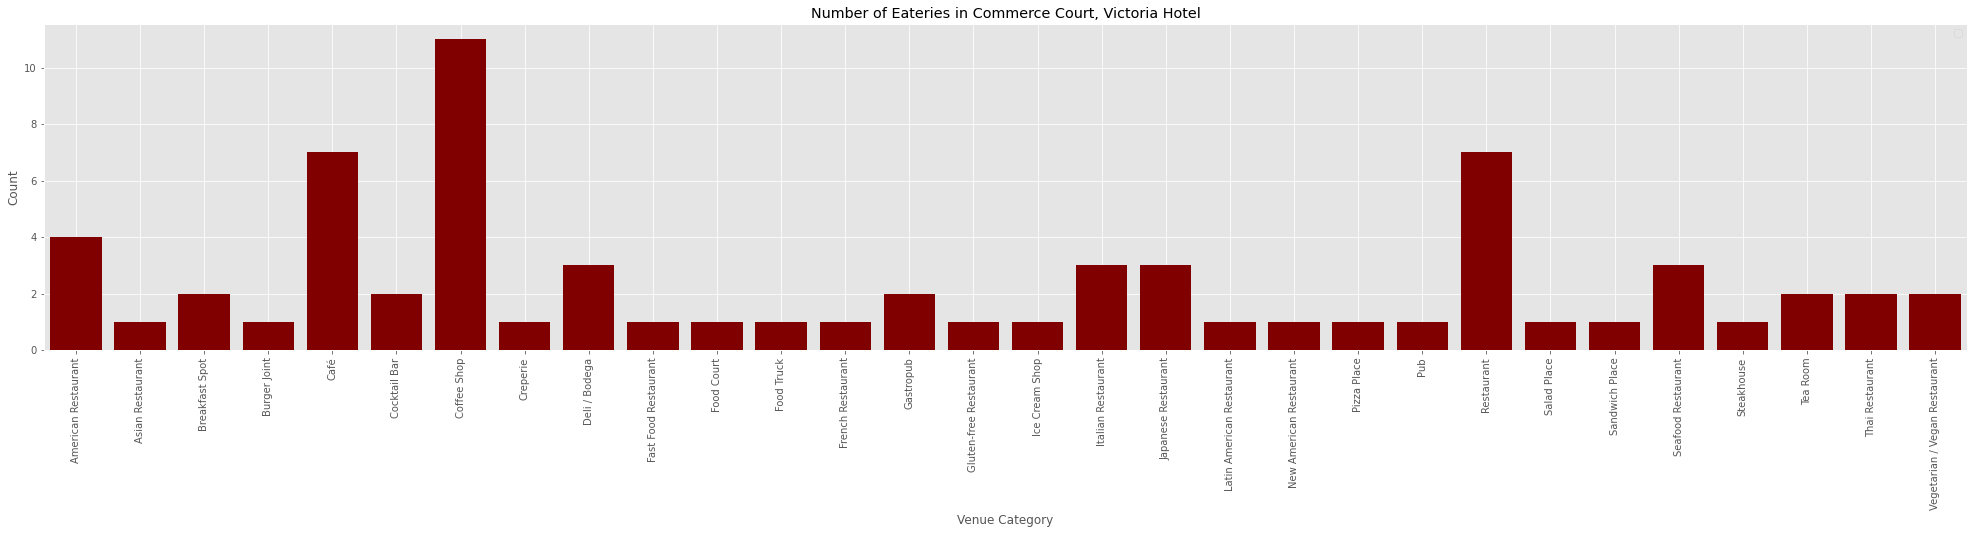

In [70]:
plt.style.use('ggplot')

nb5_venue.plot(kind='bar', figsize=(30, 10))
x = nb5_venue['Venue Category']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,nb5_venue['Count'] , color='maroon')
plt.xlabel("Venue Category")
plt.ylabel("Count")
plt.title("Number of Eateries in Commerce Court, Victoria Hotel")

plt.legend('')  
plt.xticks(x_pos, x)

plt.tight_layout(pad=10.0,w_pad=10.0,h_pad=10.0)
plt.show()

#### CREATE A DATAFRAME WITH NEIGHBORHOOD AND NUMBER OF EATERIES IN EACH NEIGHBORHOOD

In [71]:
eateries_data = df_max.copy()
eateries_data['Eateries'] = np.nan
eateries_data

Neighborhood  Eateries
0                     Commerce Court, Victoria Hotel       NaN
1             First Canadian Place, Underground city       NaN
2                           Garden District, Ryerson       NaN
3  Harbourfront East, Union Station, Toronto Islands       NaN
4           Toronto Dominion Centre, Design Exchange       NaN

In [72]:
place = 'Eateries' 
#Harbourfront east    
eateries_data.at[3,'Eateries'] = totalv1
#Toronto Dominion Centre
eateries_data.at[4,'Eateries'] = totalv2
#First Canadian Place
eateries_data.at[1,'Eateries'] = totalv3
#Garden District
eateries_data.at[2,'Eateries'] = totalv4
#Commerce Court
eateries_data.at[0,'Eateries'] = totalv5

eateries_data.dropna(axis=1)



Neighborhood  Eateries
0                     Commerce Court, Victoria Hotel      69.0
1             First Canadian Place, Underground city      70.0
2                           Garden District, Ryerson      49.0
3  Harbourfront East, Union Station, Toronto Islands      43.0
4           Toronto Dominion Centre, Design Exchange      64.0

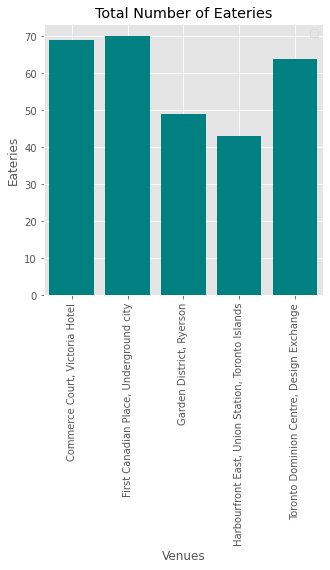

In [73]:
plt.style.use('ggplot')

eateries_data.plot(kind='bar', figsize=(5, 5))
x = eateries_data['Neighborhood']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos,eateries_data['Eateries'] , color='teal')
plt.xlabel("Venues")
plt.ylabel("Eateries")
plt.title("Total Number of Eateries")

plt.legend('')  
plt.xticks(x_pos, x)

plt.show()

### NOTE:
The above bar chart shows that First Canadian Place and Commerce Court have the highest number of venues. This gives an indication of the density of the clientele; more people equal more foot traffic which means more business.

#### CREATE A DATAFRAME WITH NEIGHBORHOOD AND NUMBER OF SUSHI RESTAURANTS IN EACH NEIGHBORHOOD

In [74]:
final_data = df_max.copy()
final_data['Sushi Restaurants'] = np.nan

In [75]:
place = 'Sushi Restaurant' 
    
for i in range(0,4):  
    #Harbourfront East
    try:
        final_data.at[3,'Sushi Restaurant'] = nb1_venue.iloc[nb1_venue[nb1_venue['Venue Category']==place].index.item()]['Count']
    except:
        final_data.at[3,'Sushi Restaurant'] = 0
        pass
    #Toronto Dominion Centre
    try:
        final_data.at[4,'Sushi Restaurant']= nb2_venue.iloc[nb2_venue[nb2_venue['Venue Category']==place].index.item()]['Count']
    except:
        final_data.at[4,'Sushi Restaurant'] = 0
        pass
    #First Canadian Place
    try:
        final_data.at[1,'Sushi Restaurant']= nb3_venue.iloc[nb3_venue[nb3_venue['Venue Category']==place].index.item()]['Count']
    except:
        final_data.at[1,'Sushi Restaurant'] = 0
        pass
    #Garden District
    try:
        final_data.at[2,'Sushi Restaurant']= nb4_venue.iloc[nb4_venue[nb4_venue['Venue Category']==place].index.item()]['Count']
    except:
        final_data.at[2,'Sushi Restaurant'] = 0
        pass
    #Commerce Court
    try:
        final_data.at[0,'Sushi Restaurant']= nb5_venue.iloc[nb5_venue[nb5_venue['Venue Category']==place].index.item()]['Count']
    except:
        final_data.at[0,'Sushi Restaurant'] = 0
        pass

In [76]:
final_data.dropna(axis=1)

Neighborhood  Sushi Restaurant
0                     Commerce Court, Victoria Hotel               0.0
1             First Canadian Place, Underground city               2.0
2                           Garden District, Ryerson               0.0
3  Harbourfront East, Union Station, Toronto Islands               1.0
4           Toronto Dominion Centre, Design Exchange               2.0

### NOTE:
The logical choice would be the neighborhood that does not currenlty have a Sushi restaurant. Therefore the choice narrows down to:
    
1 - Commerce Court, Victoria Hotel

2 - Garden District, Ryerson

In [77]:
address = 'Commerce Court, Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinates of Commerce Court are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinates of Commerce Court are 43.64809515, -79.37902543099575.


In [78]:
address = 'Garden District, Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude2 = location.latitude
longitude2 = location.longitude
print('The geograpical coordinates of Garden District are {}, {}.'.format(latitude2, longitude2))

The geograpical coordinates of Garden District are 43.6564995, -79.3771141.


In [79]:
choice_l = {'Neighborhood':['Commerce Court','Garden District'],'Latitude':[latitude1,latitude2],'Longitude':[longitude1,longitude2]}
choice_location = pd.DataFrame(choice_l,columns=['Neighborhood','Latitude','Longitude'])
choice_location

Neighborhood   Latitude  Longitude
0   Commerce Court  43.648095 -79.379025
1  Garden District  43.656500 -79.377114

In [80]:
map_choice_venues = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng,neighborhood in zip(choice_location['Latitude'],choice_location['Longitude'],choice_location['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_choice_venues)  
    
map_choice_venues

## Final Choice

####Data analysis using machine learning

Lets start with the ML data analysis.

The ML technique used here is the unsupervised ML K-means clustering technique. The algorithm was given the five neighborhoods chosen for the most density of venues to reveal which locations have what types of venues as the most favored.  

Applying this technique has clearly shown that locations that have eateries in the top five venues are correctly clustered together and the one neighborhood out of the five which has the top most favored/common venue as a 'Clothing Store' is kept away as a lone cluster.  

The ML technique has indicated that investing in an eatery of any kind in Cluster 0 neighborhoods will be most optimum.  The neighborhoods in Cluster 0 are Toronto Dominion Centre, Design Centre, Commerce Court, Victoria Hotel, First Canadian Place, Underground city

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

To make the final choice of location the two main criteria for selection must be fullfilled. 

They are:

1)The location must ensure the most business in terms of customers visits. 

Commerce Court is a venue with the second highest number of eateries and one which also has one of the highest number of venues overall among all the neighborhoods in the City of Toronto. This is an indicator of the density of people traffic which is a prime requirement when looking for high volume of business.

Since Commerce Court neighborhood is in the financial district of the city, we can expect the highest number of well-heeled clientele who have a penchant for fine dining. A Sushi restaurant marketed as an upscale eatery will be very profitable in this location.  And if it matters at all, Commerce Court is only about one km from the lake (Lake Ontario) which makes for better atmosphere well appreciated by all.


2)The location must be where there are currently few or no restaurants of the same type.

The data shows that Commerce Court neighborhood has no Sushi Restaurants.

Finally, through data analysis using Data Science techniques, Commerce Court is in Cluster 0 which give added confidence in declaring to the client that Commerce Court is the best possible choice of location to start their dream Sushi Restaurant.




### So, we have a winner in the battle of the Neighborhoods and the winner is:

##     *********   The Neighborhood of Commerce Court   *********